## Limpeza dos dados

In [4]:
import pandas as pd
import datetime
import numpy as np

In [10]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/JackyP/testing/master/datasets/nycflights.csv",
    index_col=0
    )
df.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute
1,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400,5.0,17.0
2,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416,5.0,33.0
3,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089,5.0,42.0
4,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576,5.0,44.0
5,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762,5.0,54.0


In [11]:
usecols=["dep_time","arr_time","carrier","flight", "tailnum","air_time","distance", "origin", "dest"]
df_raw = df.loc[
    (~df["arr_time"].isna()) \
    & (~df["dep_time"].isna()) \
    & (~df["carrier"].isna()) \
    & (~df["flight"].isna())
].loc[:, usecols]

In [12]:
df_raw["air_time"] = df_raw["air_time"].fillna(0)
df_raw.drop_duplicates(inplace=True)
df_raw = df_raw.astype("object")

In [13]:
tmp = df.loc[:, usecols].copy()
for col in ["arr_time", "dep_time", "carrier", "flight"]:
    tmp_df = tmp.loc[~df[col].isna()]
    tmp = tmp_df.copy()

tmp.drop_duplicates(inplace=True)
tmp.shape[0] == df_raw.shape[0]

tmp.head()

,dep_time,arr_time,carrier,flight,tailnum,air_time,distance,origin,dest
1,517.0,830.0,UA,1545,N14228,227.0,1400,EWR,IAH
2,533.0,850.0,UA,1714,N24211,227.0,1416,LGA,IAH
3,542.0,923.0,AA,1141,N619AA,160.0,1089,JFK,MIA
4,544.0,1004.0,B6,725,N804JB,183.0,1576,JFK,BQN
5,554.0,812.0,DL,461,N668DN,116.0,762,LGA,ATL


In [14]:
new_columns = ["datetime_partida", "datetime_chegada", "companhia", "id_voo", "id_aeronave","tempo_voo", "distancia", "origem", "destino"]
columns_map = {usecols[i]: new_columns[i] for i in range(len(usecols))}
columns_map

{'dep_time': 'datetime_partida',
 'arr_time': 'datetime_chegada',
 'carrier': 'companhia',
 'flight': 'id_voo',
 'tailnum': 'id_aeronave',
 'air_time': 'tempo_voo',
 'distance': 'distancia',
 'origin': 'origem',
 'dest': 'destino'}

In [15]:
df_work = df_raw.copy()
df_work.rename(columns=columns_map, inplace=True)
df_work.head()

,datetime_partida,datetime_chegada,companhia,id_voo,id_aeronave,tempo_voo,distancia,origem,destino
1,517.0,830.0,UA,1545,N14228,227.0,1400,EWR,IAH
2,533.0,850.0,UA,1714,N24211,227.0,1416,LGA,IAH
3,542.0,923.0,AA,1141,N619AA,160.0,1089,JFK,MIA
4,544.0,1004.0,B6,725,N804JB,183.0,1576,JFK,BQN
5,554.0,812.0,DL,461,N668DN,116.0,762,LGA,ATL


In [16]:
df_work["tempo_voo"] = df_work.loc[:,"tempo_voo"].astype(float)
df_work["distancia"] = df_work.loc[:,"distancia"].astype(float)
df_work["companhia"] = df_work.loc[:,"companhia"].astype(str)
df_work["id_voo"] = df_work.loc[:,"id_voo"].astype(str)
df_work["id_aeronave"] = df_work.loc[:,"id_aeronave"].astype(str)
df_work["datetime_partida"] = df_work.loc[:,"datetime_partida"].astype(str)
df_work["datetime_chegada"] = df_work.loc[:,"datetime_chegada"].astype(str)
df_work["origem"] = df_work.loc[:,"origem"].astype(str)
df_work["destino"] = df_work.loc[:,"destino"].astype(str)

In [17]:
import re

def padroniza_str(obs):
    return re.sub('[^A-Za-z0-9]+', '', obs.upper())

In [18]:
df_work["companhia_formatted"] = df_work.loc[:,"companhia"].apply(lambda x: padroniza_str(x))
df_work["id_voo_formatted"] = df_work.loc[:,"id_voo"].apply(lambda x: padroniza_str(x))
df_work["id_aeronave_formatted"] = df_work.loc[:,"id_aeronave"].apply(lambda x: padroniza_str(x))
df_work["origem_formatted"] = df_work.loc[:,"origem"].apply(lambda x: padroniza_str(x))
df_work["destino_formatted"] = df_work.loc[:,"destino"].apply(lambda x: padroniza_str(x))

In [19]:
df_work.loc[:,"datetime_partida"] = df_work.loc[:,"datetime_partida"].str.replace('.0', '')
df_work.loc[:,"datetime_chegada"] = df_work.loc[:,"datetime_chegada"].str.replace('.0', '')
df_work["data_voo"] = pd.to_datetime(df[['year', 'month', 'day']]) 

In [20]:
df_work["datetime_partida"].apply(lambda x: len(x)).unique()

array([3, 4, 2, 1])

In [21]:
def corrige_hora(hr_str,dct_hora = {1:"000?",2:"00?",3:"0?",4:"?"}):
    if hr_str == "2400":
        return "00:00"
    elif (len(hr_str) == 2) & (int(hr_str) <= 12):
        return f"0{hr_str[0]}:{hr_str[1]}0"
    else:
        hora = dct_hora[len(hr_str)].replace("?", hr_str)
        return f"{hora[:2]}:{hora[2:]}"

In [22]:
datetime_partida2 = df_work.loc[:,"datetime_partida"].apply(lambda x: corrige_hora(x))
datetime_chegada2 = df_work.loc[:,"datetime_chegada"].apply(lambda x: corrige_hora(x))

In [23]:
pd.to_datetime(df_work.loc[:,'data_voo'].astype(str) + " " + datetime_partida2)

1        2013-01-01 05:17:00
2        2013-01-01 05:33:00
3        2013-01-01 05:42:00
4        2013-01-01 05:44:00
5        2013-01-01 05:54:00
                 ...        
336766   2013-09-30 22:40:00
336767   2013-09-30 22:40:00
336768   2013-09-30 22:41:00
336769   2013-09-30 23:07:00
336770   2013-09-30 23:49:00
Length: 328038, dtype: datetime64[ns]

In [24]:
df_work['datetime_partida_formatted'] = pd.to_datetime(df_work.loc[:,'data_voo'].astype(str) + " " + datetime_partida2)
df_work['datetime_chegada_formatted'] = pd.to_datetime(df_work.loc[:,'data_voo'].astype(str) + " " + datetime_chegada2)

In [25]:
df_work.head()

,datetime_partida,datetime_chegada,companhia,id_voo,id_aeronave,tempo_voo,distancia,origem,destino,companhia_formatted,id_voo_formatted,id_aeronave_formatted,origem_formatted,destino_formatted,data_voo,datetime_partida_formatted,datetime_chegada_formatted
1,517,830,UA,1545,N14228,227.0,1400.0,EWR,IAH,UA,1545,N14228,EWR,IAH,2013-01-01,2013-01-01 05:17:00,2013-01-01 08:30:00
2,533,850,UA,1714,N24211,227.0,1416.0,LGA,IAH,UA,1714,N24211,LGA,IAH,2013-01-01,2013-01-01 05:33:00,2013-01-01 08:50:00
3,542,923,AA,1141,N619AA,160.0,1089.0,JFK,MIA,AA,1141,N619AA,JFK,MIA,2013-01-01,2013-01-01 05:42:00,2013-01-01 09:23:00
4,544,1004,B6,725,N804JB,183.0,1576.0,JFK,BQN,B6,725,N804JB,JFK,BQN,2013-01-01,2013-01-01 05:44:00,2013-01-01 10:04:00
5,554,812,DL,461,N668DN,116.0,762.0,LGA,ATL,DL,461,N668DN,LGA,ATL,2013-01-01,2013-01-01 05:54:00,2013-01-01 08:12:00


In [26]:
df_work.loc[df_work["datetime_partida_formatted"] > df_work["datetime_chegada_formatted"]]

,datetime_partida,datetime_chegada,companhia,id_voo,id_aeronave,tempo_voo,distancia,origem,destino,companhia_formatted,id_voo_formatted,id_aeronave_formatted,origem_formatted,destino_formatted,data_voo,datetime_partida_formatted,datetime_chegada_formatted
720,1929,3,UA,1071,N27205,192.0,1585.0,EWR,BQN,UA,1071,N27205,EWR,BQN,2013-01-01,2013-01-01 19:29:00,2013-01-01 00:03:00
726,1939,29,9E,3325,N905XJ,0.0,1391.0,JFK,DFW,9E,3325,N905XJ,JFK,DFW,2013-01-01,2013-01-01 19:39:00,2013-01-01 00:29:00
792,2058,8,UA,1241,N27724,159.0,997.0,EWR,TPA,UA,1241,N27724,EWR,TPA,2013-01-01,2013-01-01 20:58:00,2013-01-01 00:08:00
795,2102,146,UA,1180,N78511,199.0,1608.0,EWR,SJU,UA,1180,N78511,EWR,SJU,2013-01-01,2013-01-01 21:02:00,2013-01-01 01:46:00
798,2108,25,UA,1517,N17245,354.0,2565.0,EWR,SFO,UA,1517,N17245,EWR,SFO,2013-01-01,2013-01-01 21:08:00,2013-01-01 00:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336754,2145,115,B6,1103,N633JB,192.0,1598.0,JFK,SJU,B6,1103,N633JB,JFK,SJU,2013-09-30,2013-09-30 21:45:00,2013-09-30 01:15:00
336755,2147,30,B6,1371,N627JB,139.0,1076.0,LGA,FLL,B6,1371,N627JB,LGA,FLL,2013-09-30,2013-09-30 21:47:00,2013-09-30 00:30:00
336763,2233,112,UA,471,N578UA,318.0,2565.0,EWR,SFO,UA,471,N578UA,EWR,SFO,2013-09-30,2013-09-30 22:33:00,2013-09-30 01:12:00
336764,2235,59,B6,1083,N804JB,123.0,944.0,JFK,MCO,B6,1083,N804JB,JFK,MCO,2013-09-30,2013-09-30 22:35:00,2013-09-30 00:59:00


In [27]:
df_dw = df_work[["data_voo",
         "companhia_formatted",
         "id_voo_formatted",
         "id_aeronave_formatted",
         "datetime_partida_formatted",
         "datetime_chegada_formatted",
         "origem_formatted",
         "destino_formatted",
         "tempo_voo",
         "distancia"]].copy()

In [28]:
df_dw["tempo_voo_esperado"] = (df_dw["datetime_chegada_formatted"] - df_dw["datetime_partida_formatted"]) / pd.Timedelta(hours=1)
df_dw["tempo_voo_hr"] = df_dw["tempo_voo"] /60
df_dw["atraso"] = df_dw["tempo_voo_hr"] - df_dw["tempo_voo_esperado"]
df_dw["dia_semana"] = df_dw["data_voo"].dt.day_of_week #0=segunda

In [29]:
def classifica_hora(hra):
    if 0 <= hra < 6: return "MADRUGADA"
    elif 6 <= hra < 12: return "MANHA"
    elif 12 <= hra < 18: return "TARDE"
    else: return "NOITE"

In [30]:
df_dw["horario"] = df_work.loc[:,"datetime_partida_formatted"].dt.hour.apply(lambda x: classifica_hora(x))

In [31]:
df_work.loc[:,"datetime_partida_formatted"].dt.hour.apply(lambda x: classifica_hora(x))

1         MADRUGADA
2         MADRUGADA
3         MADRUGADA
4         MADRUGADA
5         MADRUGADA
            ...    
336766        NOITE
336767        NOITE
336768        NOITE
336769        NOITE
336770        NOITE
Name: datetime_partida_formatted, Length: 328038, dtype: object

In [32]:
df_filtrada = df_dw[df_dw["atraso"]>-1].copy()

In [33]:
def flg_status(atraso):
    if atraso > 1 : return "ATRASO"
    else: return "ONTIME"

In [34]:
def flg_status_num(atraso):
    if atraso > 1 : return 1
    else: return 0

In [35]:
df_filtrada["flg_status"] = df_filtrada.loc[:,"atraso"].apply(lambda x: flg_status(x))
df_filtrada["flg_status_num"] = df_filtrada.loc[:,"atraso"].apply(lambda x: flg_status_num(x))

In [218]:
df_filtrada2 = df_filtrada[df_filtrada["tempo_voo_esperado"]>0].copy()
df_filtrada2.sort_values(by='atraso', ascending=False).head()

,data_voo,companhia_formatted,id_voo_formatted,id_aeronave_formatted,datetime_partida_formatted,datetime_chegada_formatted,origem_formatted,destino_formatted,tempo_voo,distancia,tempo_voo_esperado,tempo_voo_hr,atraso,dia_semana,horario,flg_status,flg_status_num
207676,2013-05-16,HA,51,N391HA,2013-05-16 09:54:00,2013-05-16 14:25:00,JFK,HNL,616.0,4983.0,4.516667,10.266667,5.750000,3,MANHA,ATRASO,1
45833,2013-10-21,HA,51,N390HA,2013-10-21 09:54:00,2013-10-21 14:41:00,JFK,HNL,632.0,4983.0,4.783333,10.533333,5.750000,0,MANHA,ATRASO,1
243231,2013-06-23,UA,15,N59053,2013-06-23 13:30:00,2013-06-23 18:04:00,EWR,HNL,619.0,4963.0,4.566667,10.316667,5.750000,6,TARDE,ATRASO,1
190787,2013-04-28,HA,51,N385HA,2013-04-28 09:54:00,2013-04-28 14:18:00,JFK,HNL,609.0,4983.0,4.400000,10.150000,5.750000,6,MANHA,ATRASO,1
317561,2013-09-10,HA,51,N383HA,2013-09-10 09:45:00,2013-09-10 14:02:00,JFK,HNL,601.0,4983.0,4.283333,10.016667,5.733333,1,MANHA,ATRASO,1


In [219]:
df_filtrada2.to_csv("nycflights_tratada.csv", index=False)

# Análises

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

In [221]:
df = pd.read_csv("nycflights_tratada.csv")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307274 entries, 0 to 307273
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   data_voo                    307274 non-null  object 
 1   companhia_formatted         307274 non-null  object 
 2   id_voo_formatted            307274 non-null  int64  
 3   id_aeronave_formatted       307274 non-null  object 
 4   datetime_partida_formatted  307274 non-null  object 
 5   datetime_chegada_formatted  307274 non-null  object 
 6   origem_formatted            307274 non-null  object 
 7   destino_formatted           307274 non-null  object 
 8   tempo_voo                   307274 non-null  float64
 9   distancia                   307274 non-null  float64
 10  tempo_voo_esperado          307274 non-null  float64
 11  tempo_voo_hr                307274 non-null  float64
 12  atraso                      307274 non-null  float64
 13  dia_semana    

In [222]:
df["data_voo"] = pd.to_datetime(df["data_voo"])
df["datetime_partida_formatted"] = pd.to_datetime(df["datetime_partida_formatted"])
df["datetime_chegada_formatted"] = pd.to_datetime(df["datetime_chegada_formatted"])
df["id_voo_formatted"] = df["id_voo_formatted"].astype(str)
df["dia_semana"] = df["dia_semana"].astype(str)

In [223]:
df.head()

,data_voo,companhia_formatted,id_voo_formatted,id_aeronave_formatted,datetime_partida_formatted,datetime_chegada_formatted,origem_formatted,destino_formatted,tempo_voo,distancia,tempo_voo_esperado,tempo_voo_hr,atraso,dia_semana,horario,flg_status,flg_status_num
0,2013-01-01,UA,1545,N14228,2013-01-01 05:17:00,2013-01-01 08:30:00,EWR,IAH,227.0,1400.0,3.216667,3.783333,0.566667,1,MADRUGADA,ONTIME,0
1,2013-01-01,UA,1714,N24211,2013-01-01 05:33:00,2013-01-01 08:50:00,LGA,IAH,227.0,1416.0,3.283333,3.783333,0.500000,1,MADRUGADA,ONTIME,0
2,2013-01-01,DL,461,N668DN,2013-01-01 05:54:00,2013-01-01 08:12:00,LGA,ATL,116.0,762.0,2.300000,1.933333,-0.366667,1,MADRUGADA,ONTIME,0
3,2013-01-01,UA,1696,N39463,2013-01-01 05:54:00,2013-01-01 07:40:00,EWR,ORD,150.0,719.0,1.766667,2.500000,0.733333,1,MADRUGADA,ONTIME,0
4,2013-01-01,B6,507,N516JB,2013-01-01 05:55:00,2013-01-01 09:13:00,EWR,FLL,158.0,1065.0,3.300000,2.633333,-0.666667,1,MADRUGADA,ONTIME,0


### 1. Quais companhias registram mais atrasos?

In [224]:
df_atrasos = df.groupby('companhia_formatted')['atraso'].agg(['mean', 'count', 'sum']).reset_index()

df_atrasos.columns = ['Companhia', 'Média Atraso', 'Qtd voos Atrasados', 'Soma Atrasos']

df_atrasos.sort_values(by='Qtd voos Atrasados', ascending=False)


,Companhia,Média Atraso,Qtd voos Atrasados,Soma Atrasos
11,UA,0.984650,55264,54415.683333
5,EV,-0.202736,49024,-9938.933333
3,B6,0.077981,46838,3652.483333
4,DL,0.251701,44604,11226.850000
1,AA,0.500137,30336,15172.150000
9,MQ,-0.243810,23868,-5819.266667
12,US,-0.173923,19181,-3336.016667
0,9E,-0.322294,15950,-5140.583333
14,WN,0.701868,11946,8384.516667
13,VX,2.499309,4968,12416.566667


In [225]:
df_atrasos.sort_values(by='Média Atraso', ascending=False).head()

,Companhia,Média Atraso,Qtd voos Atrasados,Soma Atrasos
8,HA,5.209893,342,1781.783333
2,AS,2.507670,704,1765.400000
13,VX,2.499309,4968,12416.566667
6,F9,1.369670,677,927.266667
11,UA,0.984650,55264,54415.683333


In [226]:

df_atrasos.sort_values(by='Soma Atrasos', ascending=False).head()

,Companhia,Média Atraso,Qtd voos Atrasados,Soma Atrasos
11,UA,0.984650,55264,54415.683333
1,AA,0.500137,30336,15172.150000
13,VX,2.499309,4968,12416.566667
4,DL,0.251701,44604,11226.850000
14,WN,0.701868,11946,8384.516667


In [227]:
df_atrasos_top10 = df_atrasos.sort_values(by='Qtd voos Atrasados', ascending=False).head(10)
df_atrasos_top10

,Companhia,Média Atraso,Qtd voos Atrasados,Soma Atrasos
11,UA,0.984650,55264,54415.683333
5,EV,-0.202736,49024,-9938.933333
3,B6,0.077981,46838,3652.483333
4,DL,0.251701,44604,11226.850000
1,AA,0.500137,30336,15172.150000
9,MQ,-0.243810,23868,-5819.266667
12,US,-0.173923,19181,-3336.016667
0,9E,-0.322294,15950,-5140.583333
14,WN,0.701868,11946,8384.516667
13,VX,2.499309,4968,12416.566667


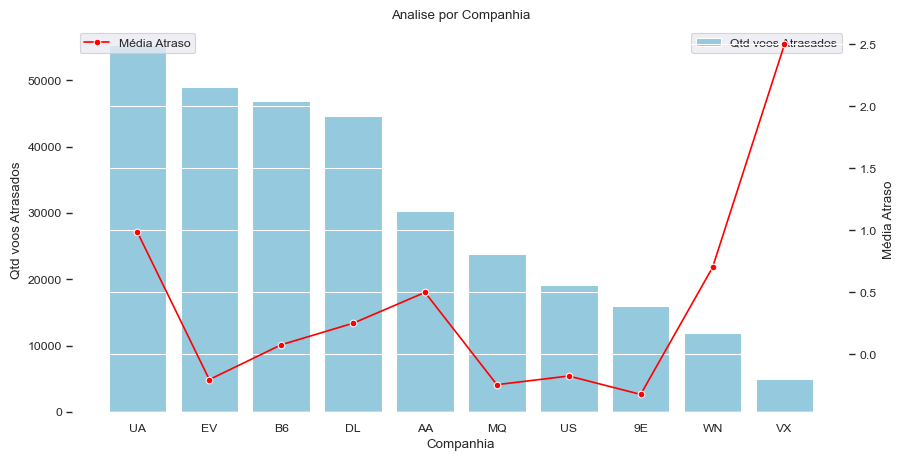

In [229]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_facecolor('white')

sns.barplot(x='Companhia', y='Qtd voos Atrasados', data=df_atrasos_top10, ax=ax, color='skyblue', label='Qtd voos Atrasados')


ax2 = ax.twinx()  
sns.lineplot(x='Companhia', y='Média Atraso', data=df_atrasos_top10, ax=ax2, color='red', marker='o', label='Média Atraso')


ax.set_ylabel('Qtd voos Atrasados')
ax2.set_ylabel('Média Atraso')
ax.set_title('Analise por Companhia')

plt.show()

### 2. A rota ou aeronave podem influenciar nos atrasos?

In [230]:
df['id_aeronave_p3'] = df['id_aeronave_formatted'].str[:3]
df['id_aeronave_u2'] = df['id_aeronave_formatted'].str[:2]

df_atrasos_nav = df.groupby('id_aeronave_p3').agg(
    Total_Voos=('atraso', 'count'),           # Conta o total de voos
    Voos_com_Atraso=('atraso', lambda x: (x > 0).sum()),  # Conta os voos com atraso
    Soma_Atrasos=('atraso', 'sum'),           # Soma total dos minutos de atraso
    Media_Atrasos=('atraso', 'mean')          # Média dos atrasos
).reset_index()

df_atrasos_nav['Proporção_Atrasos'] = df_atrasos_nav['Voos_com_Atraso'] / df_atrasos_nav['Total_Voos']

df_atrasos_nav.sort_values(by=['Media_Atrasos'], ascending=[False]).head()

,id_aeronave_p3,Total_Voos,Voos_com_Atraso,Soma_Atrasos,Media_Atrasos,Proporção_Atrasos
31,N38,2802,1776,3737.683333,1.333934,0.633833
76,N62,3393,1958,3796.950000,1.119054,0.577070
32,N39,2723,1640,2637.783333,0.968705,0.602277
77,N63,4070,2057,3760.050000,0.923845,0.505405
65,N57,2392,1641,2130.466667,0.890663,0.686037


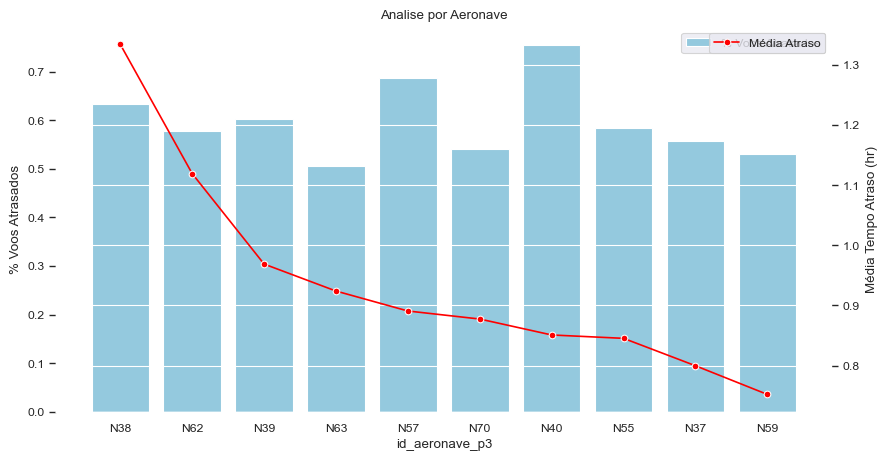

In [231]:
df_atrasos_nav_top10=df_atrasos_nav.sort_values(by=['Media_Atrasos'], ascending=[False]).head(10)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_facecolor('white')

sns.barplot(x='id_aeronave_p3', y='Proporção_Atrasos', data=df_atrasos_nav_top10, ax=ax, color='skyblue', label='% Voos Atrasados')


ax2 = ax.twinx()  
sns.lineplot(x='id_aeronave_p3', y='Media_Atrasos', data=df_atrasos_nav_top10, ax=ax2, color='red', marker='o', label='Média Atraso')


ax.set_ylabel('% Voos Atrasados')
ax2.set_ylabel('Média Tempo Atraso (hr)')
ax.set_title('Analise por Aeronave')

plt.show()

In [232]:
df_atrasos_nav = df.groupby('id_aeronave_formatted')['atraso'].agg(['mean', 'count', 'sum']).reset_index()

df_atrasos_nav.columns = ['ID Aeronave', 'Média Atraso', 'Qtd voos Atrasados', 'Soma Atrasos']

df_atrasos_nav.sort_values(by=['Soma Atrasos','Qtd voos Atrasados'], ascending=[False,False]).head(10)

,ID Aeronave,Média Atraso,Qtd voos Atrasados,Soma Atrasos
749,N328AA,2.243875,351,787.600000
797,N338AA,2.242464,345,773.650000
785,N335AA,2.135180,352,751.583333
746,N327AA,2.124225,344,730.733333
754,N329AA,2.276452,310,705.700000
788,N336AA,2.182766,323,705.033333
729,N323AA,2.178209,322,701.383333
716,N319AA,2.156688,319,687.983333
1745,N502UA,2.431115,278,675.850000
1807,N512UA,2.466606,273,673.383333


In [233]:
df_atrasos_rota = df.groupby(['origem_formatted','destino_formatted'])['atraso'].agg(['mean', 'count', 'sum']).reset_index()

df_atrasos_rota.columns = ['Origem','Destino', 'Média Atraso', 'Qtd voos Atrasados', 'Soma Atrasos']

df_atrasos_rota.sort_values(by=['Média Atraso','Qtd voos Atrasados'], ascending=[False,False]).head(10)

,Origem,Destino,Média Atraso,Qtd voos Atrasados,Soma Atrasos
108,JFK,HNL,5.209893,342,1781.783333
31,EWR,HNL,5.204469,358,1863.200000
1,EWR,ANC,3.508333,8,28.066667
135,JFK,PSP,2.657407,18,47.833333
57,EWR,PDX,2.537112,547,1387.800000
67,EWR,SAN,2.527892,1115,2818.600000
73,EWR,SFO,2.518843,4848,12211.350000
76,EWR,SNA,2.516092,812,2043.066667
117,JFK,LGB,2.514424,654,1644.433333
38,EWR,LAS,2.512270,1975,4961.733333


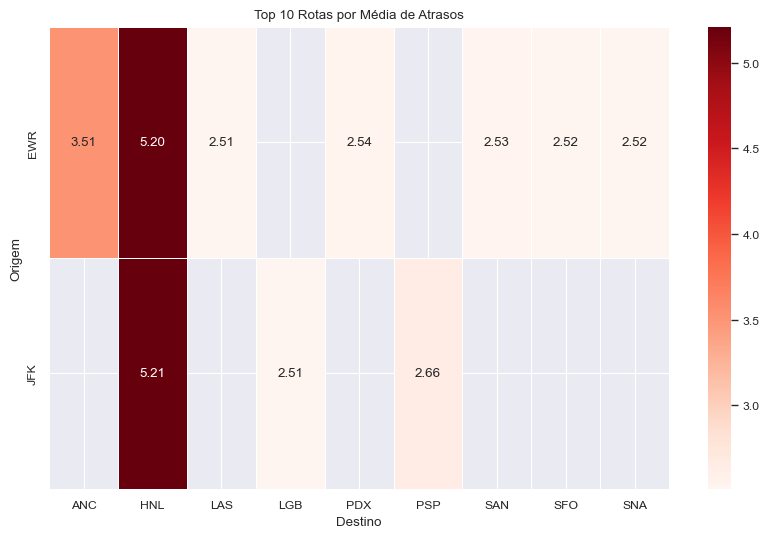

In [234]:
top_10 = df_atrasos_rota.sort_values(by=['Média Atraso','Qtd voos Atrasados'], ascending=[False,False]).head(10)

df_rota_top10 = top_10.pivot(index='Origem', columns='Destino', values='Média Atraso')

plt.figure(figsize=(10, 6))
sns.heatmap(df_rota_top10, annot=True, cmap="Reds", fmt=".2f", linewidths=.5)


plt.title('Top 10 Rotas por Média de Atrasos')
plt.show()


### 3. Existe algum padrão ou tendência nos atrasos?

In [235]:
df['hora_partida'] = df['datetime_partida_formatted'].dt.hour
df['mes'] = df['datetime_partida_formatted'].dt.month
df.columns
df.head()

,data_voo,companhia_formatted,id_voo_formatted,id_aeronave_formatted,datetime_partida_formatted,datetime_chegada_formatted,origem_formatted,destino_formatted,tempo_voo,distancia,...,tempo_voo_hr,atraso,dia_semana,horario,flg_status,flg_status_num,id_aeronave_p3,id_aeronave_u2,hora_partida,mes
0,2013-01-01,UA,1545,N14228,2013-01-01 05:17:00,2013-01-01 08:30:00,EWR,IAH,227.0,1400.0,...,3.783333,0.566667,1,MADRUGADA,ONTIME,0,N14,N1,5,1
1,2013-01-01,UA,1714,N24211,2013-01-01 05:33:00,2013-01-01 08:50:00,LGA,IAH,227.0,1416.0,...,3.783333,0.500000,1,MADRUGADA,ONTIME,0,N24,N2,5,1
2,2013-01-01,DL,461,N668DN,2013-01-01 05:54:00,2013-01-01 08:12:00,LGA,ATL,116.0,762.0,...,1.933333,-0.366667,1,MADRUGADA,ONTIME,0,N66,N6,5,1
3,2013-01-01,UA,1696,N39463,2013-01-01 05:54:00,2013-01-01 07:40:00,EWR,ORD,150.0,719.0,...,2.500000,0.733333,1,MADRUGADA,ONTIME,0,N39,N3,5,1
4,2013-01-01,B6,507,N516JB,2013-01-01 05:55:00,2013-01-01 09:13:00,EWR,FLL,158.0,1065.0,...,2.633333,-0.666667,1,MADRUGADA,ONTIME,0,N51,N5,5,1


In [236]:
df_agg = df.groupby('mes')['atraso'].agg(['mean', 'count', 'sum']).reset_index()
df_agg.sort_values(by='count', ascending=False)

,mes,mean,count,sum
9,10,0.295223,27753,8193.316667
7,8,0.307845,26941,8293.650000
4,5,0.282591,26687,7541.500000
2,3,0.219857,26354,5794.100000
8,9,0.303412,26060,7906.916667
3,4,0.245883,25738,6328.533333
10,11,0.282894,25674,7263.033333
6,7,0.291084,25493,7420.616667
0,1,0.233142,24843,5791.950000
5,6,0.309214,24800,7668.516667


In [237]:
df.columns

Index(['data_voo', 'companhia_formatted', 'id_voo_formatted',
       'id_aeronave_formatted', 'datetime_partida_formatted',
       'datetime_chegada_formatted', 'origem_formatted', 'destino_formatted',
       'tempo_voo', 'distancia', 'tempo_voo_esperado', 'tempo_voo_hr',
       'atraso', 'dia_semana', 'horario', 'flg_status', 'flg_status_num',
       'id_aeronave_p3', 'id_aeronave_u2', 'hora_partida', 'mes'],
      dtype='object')

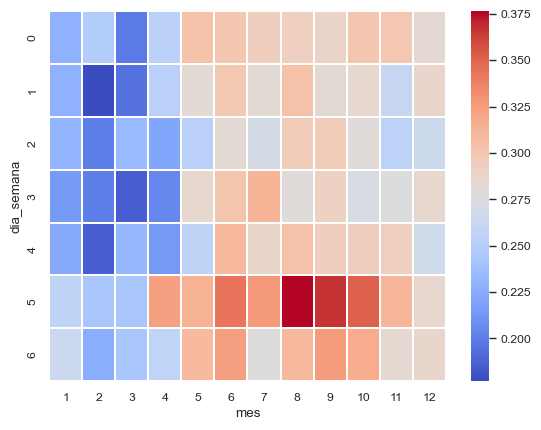

In [267]:
tmp = df.pivot_table(index="dia_semana", values='atraso', columns="mes", aggfunc="mean")

# plt.figure(figsize=(10, 6))
# sns.heatmap(tmp, annot=True, cmap="Reds", fmt=".1f", linewidths=.5)

sns.heatmap(tmp, linewidths=0.01, cmap="coolwarm");

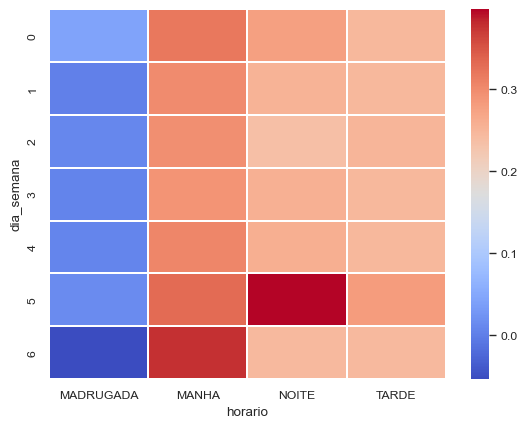

In [263]:
tmp = df.pivot_table(index="dia_semana", values='atraso', columns="horario", aggfunc="mean")

# plt.figure(figsize=(10, 6))
# sns.heatmap(tmp, annot=True, cmap="Reds", fmt=".1f", linewidths=.5)

sns.heatmap(tmp, linewidths=0.01, cmap="coolwarm");

In [92]:
import sklearn

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [94]:
metrics = ['roc_auc', 'accuracy', 'precision', 'recall']

In [111]:
exclude_cols = ["id_aeronave_formatted", "destino_formatted", "id_voo_formatted"]
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in exclude_cols]
df_categorical = df[categorical_cols].copy()
for col in categorical_cols:
    if df_categorical[col].nunique() == 2:
        df_categorical[col], _ = pd.factorize(df_categorical[col])
    else:
        df_categorical = pd.get_dummies(df_categorical, columns=[col])

In [115]:
num_cols = [c for c in df.columns if df[c].dtype == 'float64' and c not in ["tempo_voo_hr", "tempo_voo"]]
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]),columns=num_cols)
df_std.head()

,distancia,tempo_voo_esperado,atraso
0,0.466417,0.411614,-0.114906
1,0.488012,0.427136,-0.129919
2,-0.394675,0.198187,-0.325085
3,-0.452711,0.074010,-0.077374
4,0.014276,0.431017,-0.392643


In [116]:
df_processed = pd.concat([df_std, df_categorical], axis=1)
df_processed.head()

,distancia,tempo_voo_esperado,atraso,flg_status,companhia_formatted_9E,companhia_formatted_AA,companhia_formatted_AS,companhia_formatted_B6,companhia_formatted_DL,companhia_formatted_EV,...,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,horario_MADRUGADA,horario_MANHA,horario_NOITE,horario_TARDE
0,0.466417,0.411614,-0.114906,0,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1,0.488012,0.427136,-0.129919,0,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
2,-0.394675,0.198187,-0.325085,0,False,False,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
3,-0.452711,0.074010,-0.077374,0,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,0.014276,0.431017,-0.392643,0,False,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False


In [114]:
df_processed.columns

Index(['distancia', 'tempo_voo_esperado', 'atraso', 'flg_status',
       'companhia_formatted_9E', 'companhia_formatted_AA',
       'companhia_formatted_AS', 'companhia_formatted_B6',
       'companhia_formatted_DL', 'companhia_formatted_EV',
       'companhia_formatted_F9', 'companhia_formatted_FL',
       'companhia_formatted_HA', 'companhia_formatted_MQ',
       'companhia_formatted_OO', 'companhia_formatted_UA',
       'companhia_formatted_US', 'companhia_formatted_VX',
       'companhia_formatted_WN', 'companhia_formatted_YV',
       'origem_formatted_EWR', 'origem_formatted_JFK', 'origem_formatted_LGA',
       'dia_semana_0', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3',
       'dia_semana_4', 'dia_semana_5', 'dia_semana_6', 'horario_MADRUGADA',
       'horario_MANHA', 'horario_NOITE', 'horario_TARDE'],
      dtype='object')

In [119]:
train_clas, test_clas = train_test_split(df_processed.drop("atraso", axis=1), test_size=0.3, random_state=50)
predictors_clas = [c for c in train_clas.columns if c not in ['flg_status', 'atraso']]

In [120]:
clf_clas = DecisionTreeClassifier()
clf_clas.fit(train_clas[predictors_clas], train_clas['flg_status'])
y_pred_clas = clf_clas.predict(test_clas[predictors_clas]) #0.5
y_prob_clas = clf_clas.predict_proba(test_clas[predictors_clas])[:, 1]

In [121]:
y_pred_clas

array([0, 0, 1, ..., 0, 1, 0])

In [122]:
results = list()
for m in metrics:
    if m == 'roc_auc':
        results.append((m, roc_auc_score(test_clas['flg_status'], y_prob_clas)))
    else:
        results.append((m, eval("{}_score".format(m))(test_clas['flg_status'], y_pred_clas)))
results

[('roc_auc', np.float64(0.9972021572610874)),
 ('accuracy', 0.9978618817536762),
 ('precision', np.float64(0.9953486118513494)),
 ('recall', np.float64(0.9947702290445983))]

In [123]:
cm = confusion_matrix(test_clas['flg_status'], y_pred_clas)
especificidade = cm[0][0]/(cm[1][0]+cm[0][0])
sensibilidade = cm[1][1]/(cm[1][1]+cm[0][1])
print(sensibilidade, especificidade)

0.9953486118513494 0.9985556090515166


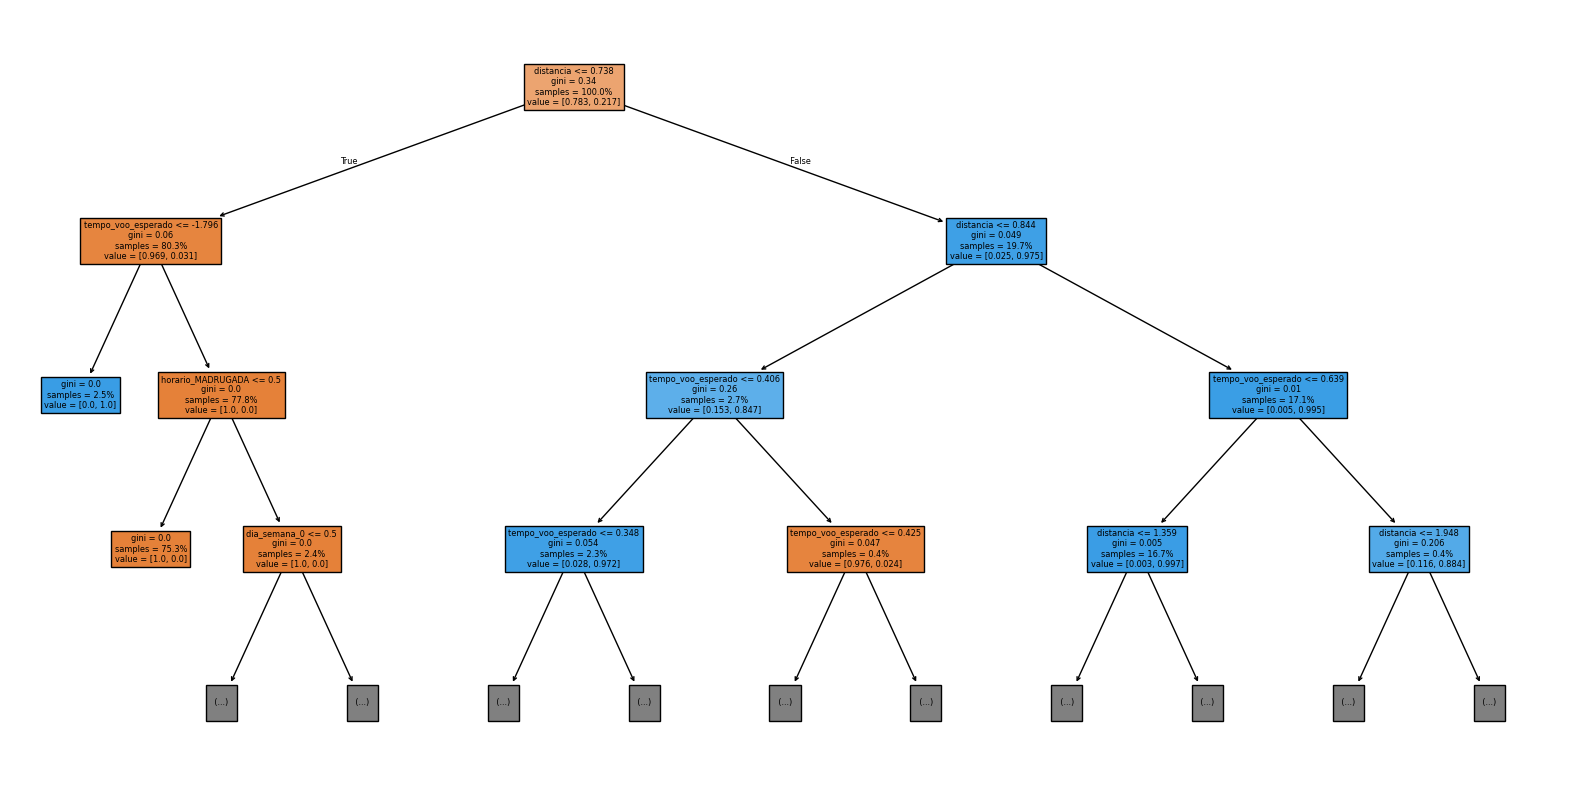

In [132]:
fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf_clas, 
                   max_depth = 3,
                   feature_names=predictors_clas,  
                   filled=True,
                   proportion=True)


In [136]:
media_target = df_processed['flg_status'].mean()
media_target

np.float64(0.21701070636879588)

In [144]:
X = df_processed.drop(['flg_status','atraso','distancia','tempo_voo_esperado'], axis=1)
y = df_processed['flg_status']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanciar o classificador de árvore de decisão
clf = DecisionTreeClassifier(random_state=42, max_depth =4) 

# Treinar o modelo
clf.fit(X_train, y_train)

# Fazer previsões
y_pred = clf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f"Acurácia: {accuracy}")
print("Matriz de Confusão:")
print(conf_matrix)

Acurácia: 0.8015742419637149
Matriz de Confusão:
[[74713    29]
 [18903  1766]]


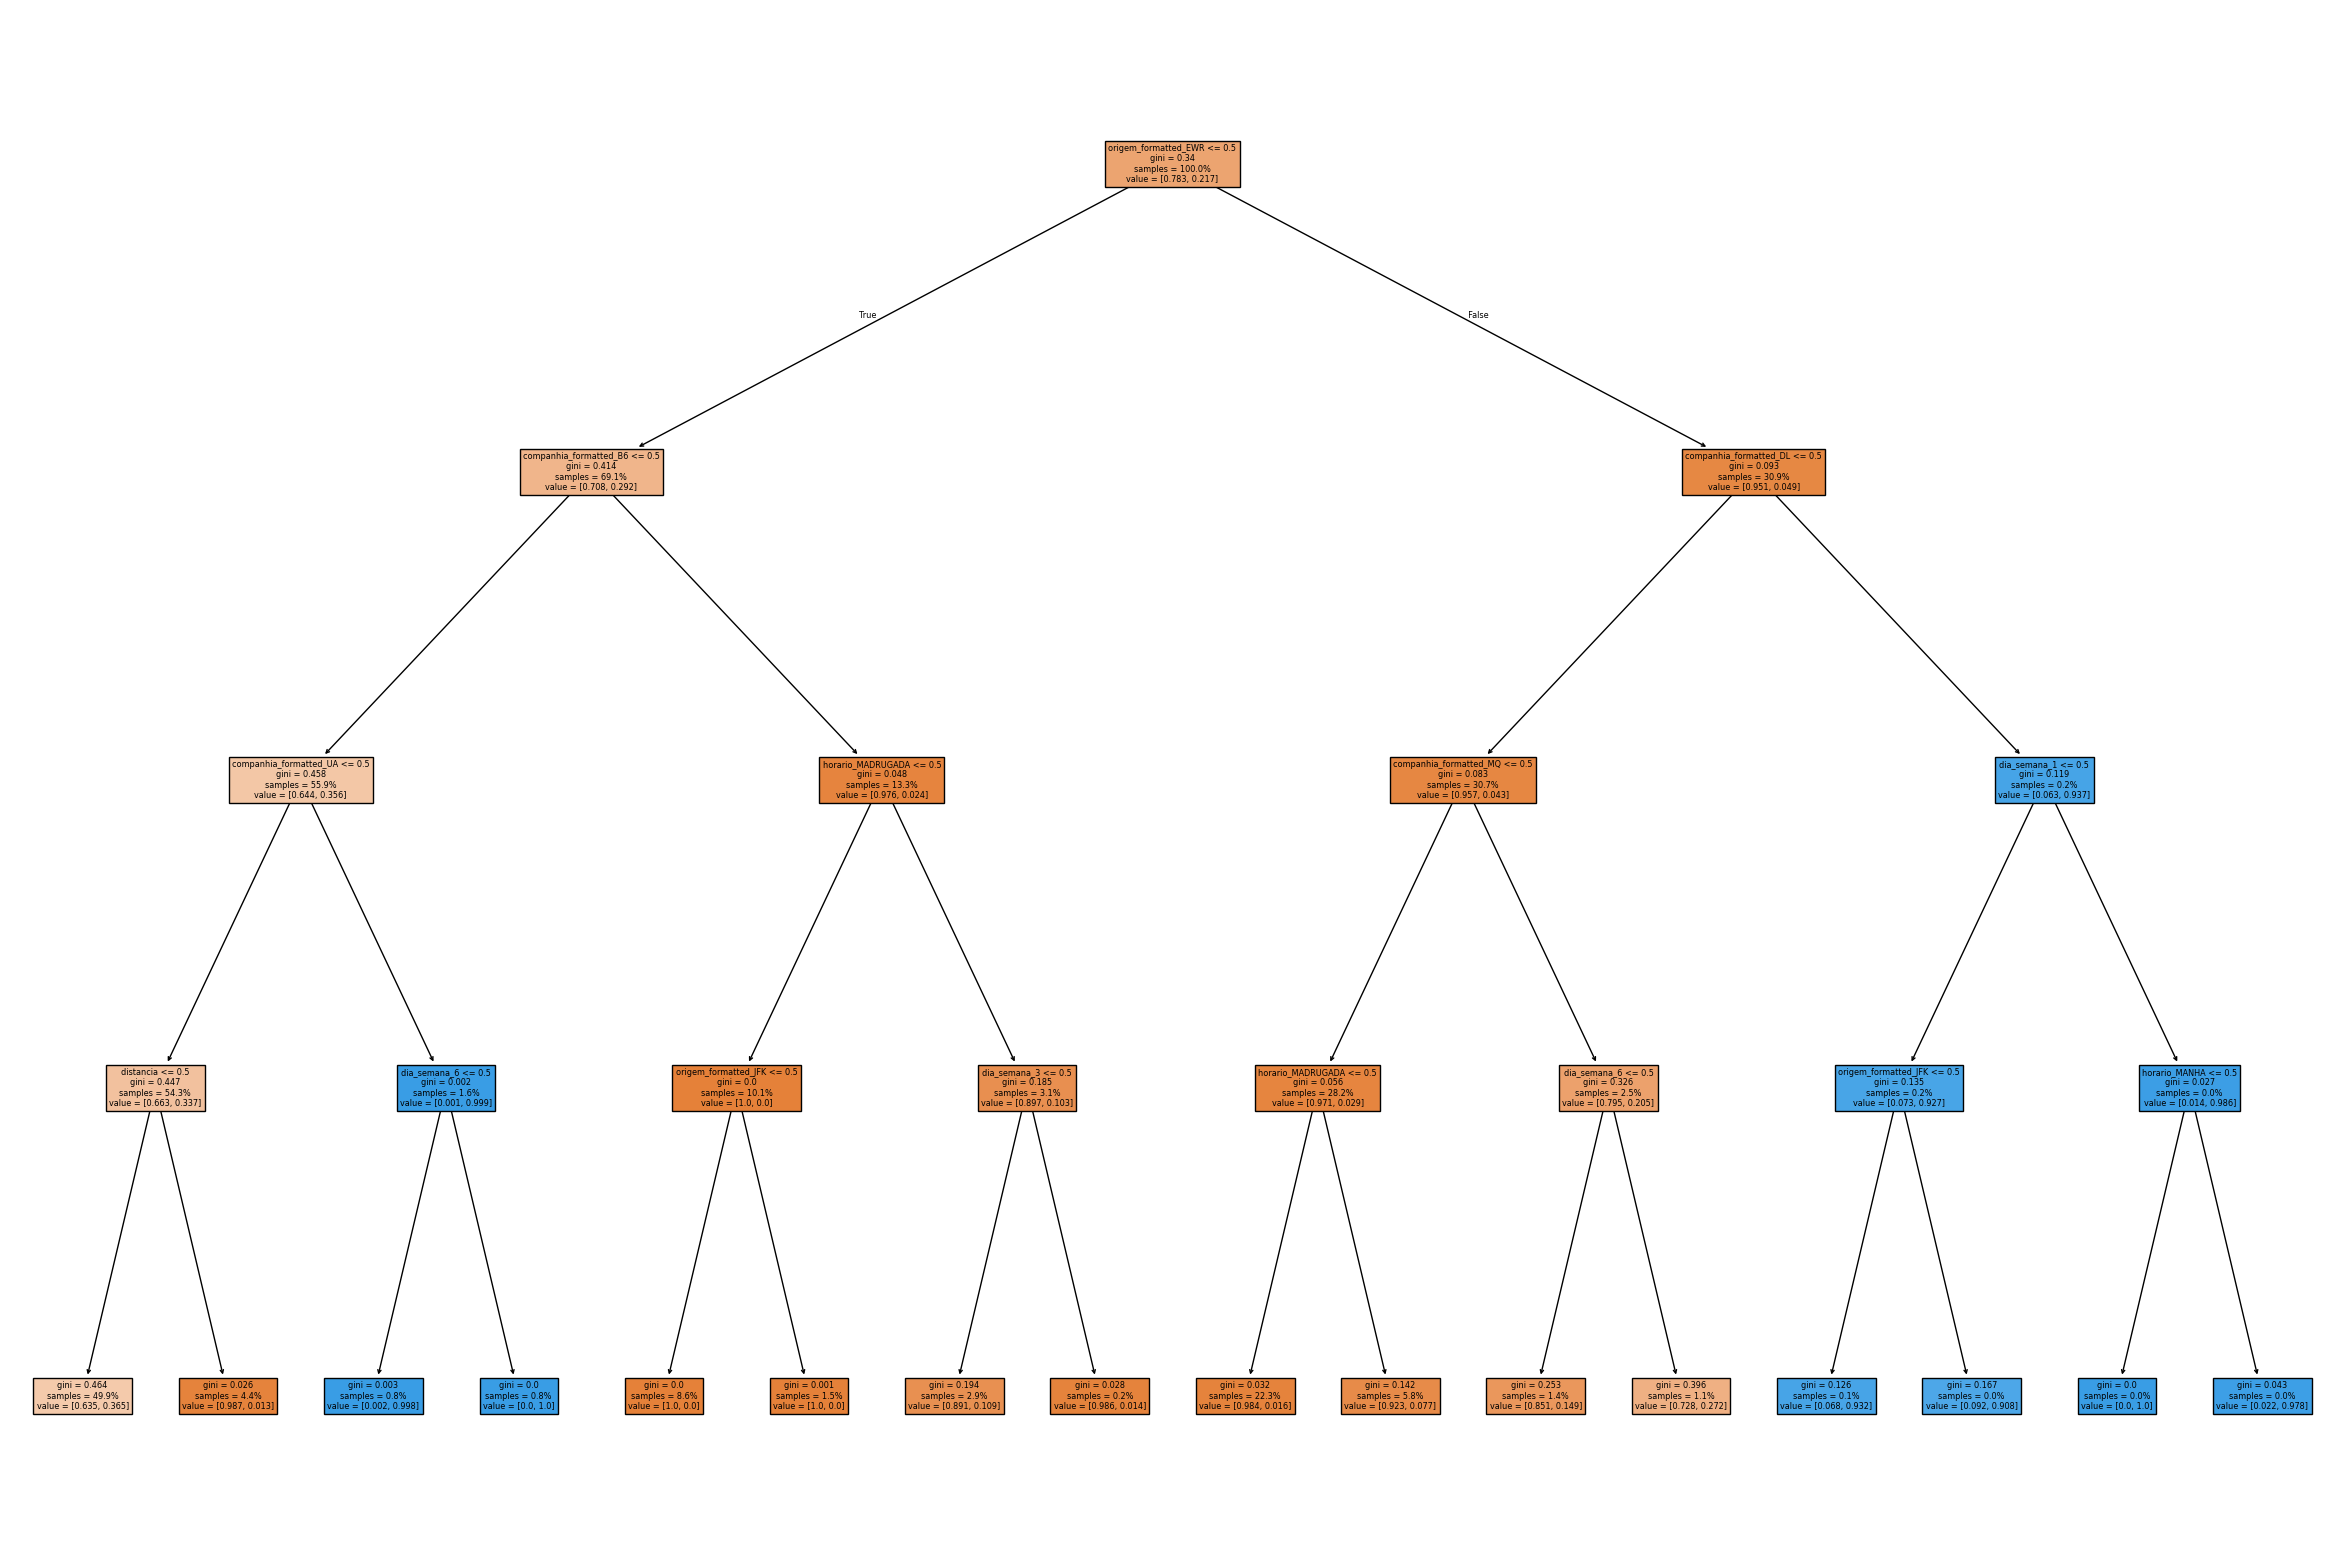

In [147]:
fig2 = plt.figure(figsize=(30,20))
_2 = tree.plot_tree(clf, 
                   max_depth = 4,
                   feature_names=predictors_clas,  
                   filled=True,
                   proportion=True)
